# Twitter Sentiment Analysis 


### Getting Tweet data from the twitter API

#### Twitter is shutting down this API for free users starting Feb. 9, 2023. This notebook should still work, but I personally don't think it's worth it  to pay for API access 

I will be using the Tweepy package to scrape tweets, since it offers a very simple interface for the authentication as well as the search method. Note that you will need to acquire a bearer token from the [Twitter Developer site](https://developer.twitter.com) to run this on your own. Anyone with a Twitter account can get developer access with just a few clicks.

The search_recent_tweets function in Tweepy allows us to search only the past 7 days. Due to the recent changes within Twitter, now only academic researchers have API access to the full historical search. 
For the search query, I added "-is:retweet" and "lang:en" to restrict my search to non-retweets and only English language. The public_metrics field stores information such as the amount of likes, retweets, and views. 

In [ ]:
#uncomment below line if running on google colab
!pip install tweepy==4.12.1 transformers vadersentiment

import tweepy
import pandas as pd

#insert your twitter auth bearer token below
btoken='AAAAAAAAAAAAAAAAAAAAAN1jlQEAAAAAPHCbpgbSR7zhGVKZi5udO7gHUXU%3Db3SLCUNLwAl8kXa1cPrIAmHdw2SO0AXKobas7QuCzwK19FkXQC'

client = tweepy.Client(bearer_token=btoken)
#add a query keyword for the tweet search
query = 'elon -is:retweet lang:en'

tweets = client.search_recent_tweets(query=query, tweet_fields=['id', 'created_at', 'text', 'public_metrics'], max_results=100)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Sentiment Analysis with VADER

I chose to use the VADER sentiment package since it is tuned to social media messages. There are other options such as TextBlob, Flair, or custom machine learning models, but VADER provides a good balance of ease of use and accuracy for Twitter text in my experience.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

tweet_df = pd.DataFrame(columns=['id','time','text','likes','retweets','views', 'v_sent', 'v_score'])

for tweet in tweets.data:
    sentiment = analyzer.polarity_scores(tweet.text)['compound']
    v_sent = 'positive' if sentiment > 0 else 'negative'
    tweet_df = tweet_df.append({'id':tweet.id,'time':tweet.created_at,'text':tweet.text,
    'likes':tweet.public_metrics['like_count'], 'retweets':tweet.public_metrics['retweet_count'], 
    'views':tweet.public_metrics['impression_count'], 'v_sent':v_sent, 'v_score':sentiment}, ignore_index=True)
tweet_df.head()

,id,time,text,likes,retweets,views,v_sent,v_score
0,1623550121630912515,2023-02-09 05:11:27+00:00,"Six weeks ago when corporate, when media misse...",0,0,0,negative,-0.7269
1,1623550112097251334,2023-02-09 05:11:25+00:00,@media_integer Elon broke it again,0,0,0,negative,-0.4215
2,1623550101091237888,2023-02-09 05:11:22+00:00,@StarkDefi 🦁 $Alcazar #Alcazar 🦁\n\n#BSC LP FA...,0,0,0,negative,0.0000
3,1623550092207869955,2023-02-09 05:11:20+00:00,So I guess Elon took everyone private,0,0,2,negative,0.0000
4,1623550091033452545,2023-02-09 05:11:20+00:00,"@PalankindelMar Terrible design, we must hang ...",0,0,0,negative,-0.4767


### Comparing results to HuggingFace deep learning model

Since VADER is a lexicon based sentiment analysis tool, it has some shortcomings in cases where context might change the sentiment of some words. To see how much this affects accuracy, we can compare to a deep learning model (in this case I am using the facebook BART model from Hugging Face). This model uses a large training set, so it should do a good job of parsing more complex phrases and contextual meanings. The model can be used with the transformers python library

This part is somewhat compute-heavy, so running it on a cloud service like Colab might be advisable if your PC doesn't have a dedicated GPU

In [ ]:
from transformers import pipeline

#note the device=0 tells the model to run on GPU. delete this if you don't have a GPU installed
classifier = pipeline(task="zero-shot-classification", 
                      model="facebook/bart-large-mnli",
                      device=0) 

# Put reviews in a list
sequences = tweet_df['text'].to_list()

# Define the candidate labels 
candidate_labels = ["positive", "negative"]

# Set the hyppothesis template
hypothesis_template = "The sentiment of this review is {}."

# Prediction results
hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

# Save the output as a dataframe
hf_prediction = pd.DataFrame(hf_prediction)
hf_prediction.head()

,sequence,labels,scores
0,"Six weeks ago when corporate, when media misse...","[negative, positive]","[0.9040865302085876, 0.09591345489025116]"
1,@media_integer Elon broke it again,"[negative, positive]","[0.9814409017562866, 0.018559066578745842]"
2,@StarkDefi 🦁 $Alcazar #Alcazar 🦁\n\n#BSC LP FA...,"[positive, negative]","[0.638081431388855, 0.3619185984134674]"
3,So I guess Elon took everyone private,"[negative, positive]","[0.9362039566040039, 0.0637960433959961]"
4,"@PalankindelMar Terrible design, we must hang ...","[negative, positive]","[0.9956324100494385, 0.004367553163319826]"


In [ ]:
# Cleaning up the results to match the existing tweet dataframe
hf_prediction['hf_sent'] = hf_prediction['labels'].apply(lambda x: x[0])

hf_prediction['hf_score'] = hf_prediction['scores'].apply(lambda x: x[0])

hf_prediction = hf_prediction.drop(['sequence','labels','scores'],axis=1)

tweet_df = pd.concat([tweet_df,hf_prediction], axis=1)
tweet_df.head()

,id,time,text,likes,retweets,views,v_sent,v_score,hf_sent,hf_score
0,1623550121630912515,2023-02-09 05:11:27+00:00,"Six weeks ago when corporate, when media misse...",0,0,0,negative,-0.7269,negative,0.904087
1,1623550112097251334,2023-02-09 05:11:25+00:00,@media_integer Elon broke it again,0,0,0,negative,-0.4215,negative,0.981441
2,1623550101091237888,2023-02-09 05:11:22+00:00,@StarkDefi 🦁 $Alcazar #Alcazar 🦁\n\n#BSC LP FA...,0,0,0,negative,0.0000,positive,0.638081
3,1623550092207869955,2023-02-09 05:11:20+00:00,So I guess Elon took everyone private,0,0,2,negative,0.0000,negative,0.936204
4,1623550091033452545,2023-02-09 05:11:20+00:00,"@PalankindelMar Terrible design, we must hang ...",0,0,0,negative,-0.4767,negative,0.995632


### Using a pie chart to visualize the difference in results

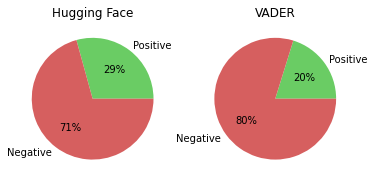

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

hf_count = [tweet_df[tweet_df['hf_sent'] == 'positive']['hf_sent'].count(), tweet_df[tweet_df['hf_sent'] == 'negative']['hf_sent'].count()]
v_count = [tweet_df[tweet_df['v_sent'] == 'positive']['v_sent'].count(), tweet_df[tweet_df['v_sent'] == 'negative']['v_sent'].count()]

palette_color = sns.color_palette('muted')
  
plt.subplot(1,2,1)
plt.title('Hugging Face')
plt.pie(hf_count, labels=['Positive','Negative'], colors=palette_color[2:4], autopct='%.0f%%')
plt.subplot(1,2,2)
plt.title('VADER')
plt.pie(v_count, labels=['Positive','Negative'], colors=palette_color[2:4], autopct='%.0f%%')
plt.show()


### Creating a SQL database to store the data

The next step is to store the data that we created for use for additional analysis or visualizations later. The to_sql function in Pandas does most of the work for us here, the only thing to be aware of is the possibility that multiple runs could result in duplicate entries. For most keywords there is enough activity that you won't see the same set of recent tweets again, but it would be advised to check for duplicates anyway.

In [ ]:
import sqlite3
#connect to database
conn = sqlite3.connect('twitter.db')
c = conn.cursor()
#create table to store tweets
#c.execute("CREATE TABLE IF NOT EXISTS sentiment(id INTEGER, time REAL, tweet TEXT, likes INTEGER, retweets INTEGER, views INTEGER, sentiment REAL)")
#conn.commit()
tweet_df.to_sql(sentiment, conn, if_exists='append', index=False)